# ItaData2024
modal example

In [2]:
using Pkg
Pkg.activate(".")
# Pkg.resolve()
# Pkg.instantiate()
# Pkg.dev("SoleModels")
# Pkg.dev("Audio911")
# Pkg.dev("SoleData")
using MLJ, ModalDecisionTrees
using SoleDecisionTreeInterface, Sole, SoleData
using CategoricalArrays
using DataFrames, JLD2, CSV
using Audio911
using Random
using StatsBase, Catch22
using Test
using Plots

  Activating project at `~/Documents/Aclai/audio-rules2024`


### Open .jld2 file
the file contains 504 samples of respiratory sound, labeled with 2 classes: healty and pneumonia

In [3]:
ds_path = "/datasets/respiratory_Healthy_Pneumonia"

d = jldopen(string((@__DIR__), ds_path, ".jld2"))
x, y = d["dataframe_validated"]
@assert x isa DataFrame
close(d)

# out of memory guard, debug purposes only
x = vcat(x[1:60, :], x[400:460, :])
y = vcat(y[1:60], y[400:460]);

### Audio features extraction function
This function is called for every audio sample and extract 51 features:
26 bands of the mel spectrogram,
13 coefficients of the mfcc
12 spectral features: centroid, crest, entropy, f0, flatness, flux, kurtosis, rolloff, skewness, decrease, slope, spread

In [4]:
nan_replacer!(x::AbstractArray{Float64}) = replace!(x, NaN => 0.0)

# function afe(x::AbstractVector{Float64}; get_only_melfreq=false)
#     # -------------------------------- parameters -------------------------------- #
#     # audio module
#     sr = 8000
#     norm = true
#     speech_detection = false
#     # stft module
#     stft_length = 1024
#     win_type = (:hann, :periodic)
#     win_length = 1024
#     overlap_length = 512
#     stft_norm = :power                      # :power, :magnitude, :pow2mag
#     # mel filterbank module
#     nbands = 26
#     scale = :mel_htk                        # :mel_htk, :mel_slaney, :erb, :bark
#     melfb_norm = :bandwidth                 # :bandwidth, :area, :none
#     freq_range = (300, round(Int, sr / 2))
#     # mel spectrogram module
#     db_scale = false
#     # mfcc module
#     ncoeffs = 13
#     rectification = :log                    # :log, :cubic_root
#     dither = true
#     # f0 module
#     method = :nfc
#     f0_range = (50, 400)

#     # --------------------------------- functions -------------------------------- #
#     # audio module
#     audio = load_audio(
#         file=x,
#         sr=sr,
#         norm=norm,
#     );

#     stftspec = get_stft(
#         audio=audio,
#         stft_length=stft_length,
#         win_type=win_type,
#         win_length=win_length,
#         overlap_length=overlap_length,
#         norm=stft_norm
#     );

#     # mel filterbank module
#     melfb = get_melfb(
#         stft=stftspec,
#         nbands=nbands,
#         scale=scale,
#         norm=melfb_norm,
#         freq_range=freq_range
#     );

#     if get_only_melfreq
#         return melfb.data.freq
#     end

#     # mel spectrogram module
#     melspec =  get_melspec(
#         stft=stftspec,
#         fbank=melfb,
#         db_scale=db_scale
#     );

#     # mfcc module
#     mfcc = get_mfcc(
#         source=melspec,
#         ncoeffs=ncoeffs,
#         rectification=rectification,
#         dither=dither,
#     );

#     # f0 module
#     f0 = get_f0(
#         source=stftspec,
#         method=method,
#         freq_range=f0_range
#     );

#     # spectral features module
#     spect = get_spectrals(
#         source=stftspec,
#         freq_range=freq_range
#     );

#     x_features = hcat(
#         melspec.spec',
#         mfcc.mfcc',
#         f0.f0,
#         spect.centroid,
#         spect.crest,
#         spect.entropy,
#         spect.flatness,
#         spect.flux,
#         spect.kurtosis,
#         spect.rolloff,
#         spect.skewness,
#         spect.decrease,
#         spect.slope,
#         spect.spread
#     );

#     nan_replacer!(x_features)

#     return x_features
# end

function afe(x::AbstractVector{Float64}; get_only_melfreq=false)
    # -------------------------------- parameters -------------------------------- #
    # audio module
    sr = 8000
    norm = true
    speech_detection = false
    # stft module
    stft_length = 1024
    win_type = (:hann, :periodic)
    win_length = 1024
    overlap_length = 512
    stft_norm = :power                      # :power, :magnitude, :pow2mag
    # mel filterbank module
    nbands = 13
    scale = :semitones                      # :mel_htk, :mel_slaney, :erb, :bark, :semitones, :tuned_semitones
    melfb_norm = :bandwidth                 # :bandwidth, :area, :none
    freq_range = (300, round(Int, sr / 2))
    # mel spectrogram module
    db_scale = true

    # --------------------------------- functions -------------------------------- #
    # audio module
    audio = load_audio(
        file=x,
        sr=sr,
        norm=norm,
    );

    stftspec = get_stft(
        audio=audio,
        stft_length=stft_length,
        win_type=win_type,
        win_length=win_length,
        overlap_length=overlap_length,
        norm=stft_norm
    );

    # mel filterbank module
    melfb = get_melfb(
        stft=stftspec,
        nbands=nbands,
        scale=scale,
        norm=melfb_norm,
        freq_range=freq_range
    );

    if get_only_melfreq
        return melfb.data.freq
    end

    # mel spectrogram module
    melspec =  get_melspec(
        stft=stftspec,
        fbank=melfb,
        db_scale=db_scale
    );

    # spectral features module
    spect = get_spectrals(
        source=stftspec,
        freq_range=freq_range
    );

    x_features = hcat(
        melspec.spec',
        spect.centroid,
        spect.crest,
        spect.entropy,
        spect.flatness,
        spect.flux,
        spect.kurtosis,
        spect.rolloff,
        spect.skewness,
        spect.decrease,
        spect.slope,
        spect.spread
    );

    nan_replacer!(x_features)

    return x_features
end

afe (generic function with 1 method)

### Compute DataFrame of features

In [5]:
color_code = Dict(:red => 31, :green => 32, :yellow => 33, :blue => 34, :magenta => 35, :cyan => 36)
freq = round.(Int, afe(x[1, :audio]; get_only_melfreq=true))
r_select = r"\e\[\d+m(.*?)\e\[0m"

# variable_names = [
#     ["\e[$(color_code[:yellow])mmel$i=$(freq[i])Hz\e[0m" for i in 1:26]...,
#     ["\e[$(color_code[:red])mmfcc$i\e[0m" for i in 1:13]...,
#     "\e[$(color_code[:green])mf0\e[0m", "\e[$(color_code[:cyan])mcntrd\e[0m", "\e[$(color_code[:cyan])mcrest\e[0m",
#     "\e[$(color_code[:cyan])mentrp\e[0m", "\e[$(color_code[:cyan])mflatn\e[0m", "\e[$(color_code[:cyan])mflux\e[0m",
#     "\e[$(color_code[:cyan])mkurts\e[0m", "\e[$(color_code[:cyan])mrllff\e[0m", "\e[$(color_code[:cyan])mskwns\e[0m",
#     "\e[$(color_code[:cyan])mdecrs\e[0m", "\e[$(color_code[:cyan])mslope\e[0m", "\e[$(color_code[:cyan])msprd\e[0m"
# ]

variable_names = [
    ["\e[$(color_code[:yellow])mmel$i=$(freq[i])Hz\e[0m" for i in 1:13]...,
    "\e[$(color_code[:cyan])mcntrd\e[0m", "\e[$(color_code[:cyan])mcrest\e[0m",
    "\e[$(color_code[:cyan])mentrp\e[0m", "\e[$(color_code[:cyan])mflatn\e[0m", "\e[$(color_code[:cyan])mflux\e[0m",
    "\e[$(color_code[:cyan])mkurts\e[0m", "\e[$(color_code[:cyan])mrllff\e[0m", "\e[$(color_code[:cyan])mskwns\e[0m",
    "\e[$(color_code[:cyan])mdecrs\e[0m", "\e[$(color_code[:cyan])mslope\e[0m", "\e[$(color_code[:cyan])msprd\e[0m"
]

X = DataFrame([name => Vector{Float64}[] for name in [match(r_select, v)[1] for v in variable_names]])

function mean_longstretch1(x) Catch22.SB_BinaryStats_mean_longstretch1((x)) end
function diff_longstretch0(x) Catch22.SB_BinaryStats_diff_longstretch0((x)) end
function quantile_hh(x) Catch22.SB_MotifThree_quantile_hh((x)) end
function sumdiagcov(x) Catch22.SB_TransitionMatrix_3ac_sumdiagcov((x)) end

nan_guard = [:std, :mean_longstretch1, :diff_longstretch0, :quantile_hh, :sumdiagcov]

for f_name in nan_guard
    @eval (function $(Symbol(string(f_name)*"+"))(channel)
        val = $(f_name)(channel)

        if isnan(val)
            SoleData.aggregator_bottom(SoleData.existential_aggregator(≥), eltype(channel))
        else
            eltype(channel)(val)
        end
    end)
    @eval (function $(Symbol(string(f_name)*"-"))(channel)
        val = $(f_name)(channel)

        if isnan(val)
            SoleData.aggregator_bottom(SoleData.existential_aggregator(≤), eltype(channel))
        else
            eltype(channel)(val)
        end
    end)
end

function get_patched_feature(f::Base.Callable, polarity::Symbol)
    if f in [minimum, maximum, StatsBase.mean, median]
        f
    else
        @eval $(Symbol(string(f)*string(polarity)))
    end
end

metaconditions = [
    (≥, get_patched_feature(maximum, :+)),            (≤, get_patched_feature(maximum, :-)),
    (≥, get_patched_feature(minimum, :+)),            (≤, get_patched_feature(minimum, :-)),
    (≥, get_patched_feature(StatsBase.mean, :+)),     (≤, get_patched_feature(StatsBase.mean, :-)),
    (≥, get_patched_feature(median, :+)),             (≤, get_patched_feature(median, :-)),
	(≥, get_patched_feature(std, :+)),                (≤, get_patched_feature(std, :-)),
	(≥, get_patched_feature(mean_longstretch1, :+)),  (≤, get_patched_feature(mean_longstretch1, :-)),
	(≥, get_patched_feature(diff_longstretch0, :+)),  (≤, get_patched_feature(diff_longstretch0, :-)),
	(≥, get_patched_feature(quantile_hh, :+)),        (≤, get_patched_feature(quantile_hh, :-)),
	(≥, get_patched_feature(sumdiagcov, :+)),         (≤, get_patched_feature(sumdiagcov, :-)),
]

for i in 1:nrow(x)
    push!(X, collect(eachcol(afe(x[i, :audio]))))
end

yc = CategoricalArray(y);

### Data compression for modal analysis

In [6]:
train_ratio = 0.8
train, test = partition(eachindex(yc), train_ratio, shuffle=true)
X_train, y_train = X[train, :], yc[train]
X_test, y_test = X[test, :], yc[test]

println("Training set size: ", size(X_train), " - ", length(y_train))
println("Test set size: ", size(X_test), " - ", length(y_test))

Training set size: (97, 24) - 97
Test set size: (24, 24) - 24


### Train a model

In [7]:
learned_dt_tree = begin
    model = ModalDecisionTree(; relations = :IA7, features = metaconditions)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
    mach = machine(model, X_train, y_train) |> fit!
end

report(learned_dt_tree).printmodel(variable_names_map=variable_names);

┌ Info: Precomputing logiset...
└ @ ModalDecisionTrees.MLJInterface /home/paso/.julia/dev/ModalDecisionTrees.jl/src/interfaces/MLJ/wrapdataset.jl:135
┌ Info: Training machine(ModalDecisionTree(max_depth = nothing, …), …).
└ @ MLJBase /home/paso/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


▣ ⟨G⟩(max[cntrd] ≥ 1007.7174434879263)
├✔ ⟨G⟩((max[cntrd] ≥ 1007.7174434879263) ∧ ⟨A̅O̅⟩(max[skwns] ≥ 4.793210481685627))
│├✔ Healthy
│└✘ ⟨G⟩((max[cntrd] ≥ 1007.7174434879263) ∧ ⟨D̅B̅E̅⟩(min[decrs] ≥ -0.00013784686085786924))
│ ├✔ Healthy
│ └✘ Pneumonia
└✘ ⟨G⟩(std-[mel12=2763Hz] ≤ 0.006494004058467565)
 ├✔ Pneumonia
 └✘ ⟨G⟩(max[mel10=1908Hz] ≤ -5.489940874016234)
  ├✔ Healthy
  └✘ Pneumonia


### Model inspection & rule study

In [8]:
_, mtree = report(mach).sprinkle(X_test, y_test)
sole_dt = ModalDecisionTrees.translate(mtree)

printmodel(sole_dt; show_metrics = true, variable_names_map=variable_names);

Applying tree... 100%|███████████████████████████████████| Time: 0:00:02


▣ ⟨G⟩(max[cntrd] ≥ 1007.7174434879263)
├✔ ⟨G⟩((max[cntrd] ≥ 1007.7174434879263) ∧ ⟨A̅O̅⟩(max[skwns] ≥ 4.793210481685627))
│├✔ Healthy : (ninstances = 4, ncovered = 4, confidence = 1.0, lift = 1.0)
│└✘ ⟨G⟩((max[cntrd] ≥ 1007.7174434879263) ∧ ⟨D̅B̅E̅⟩(min[decrs] ≥ -0.00013784686085786924))
│ ├✔ Healthy : (ninstances = 1, ncovered = 1, confidence = 1.0, lift = 1.0)
│ └✘ Pneumonia : (ninstances = 4, ncovered = 4, confidence = 0.25, lift = 1.0)
└✘ ⟨G⟩(std-[mel12=2763Hz] ≤ 0.006494004058467565)
 ├✔ ⟨G⟩((std-[mel12=2763Hz] ≤ 0.006494004058467565) ∧ (max[mel2=434Hz] ≥ -1.2940729374163782))
 │├✔ Pneumonia : (ninstances = 3, ncovered = 3, confidence = 0.67, lift = 1.0)
 │└✘ Pneumonia : (ninstances = 5, ncovered = 5, confidence = 0.8, lift = 1.0)
 └✘ ⟨G⟩(max[mel10=1908Hz] ≤ -5.489940874016234)
  ├✔ Healthy : (ninstances = 2, ncovered = 2, confidence = 0.5, lift = 1.0)
  └✘ ⟨G⟩(max[mel1=361Hz] ≥ -0.9689609258628422)
   ├✔ Pneumonia : (ninstances = 4, ncovered = 4, confidence = 0.5, lift = 1.0)
   

### Extract rules that are at least as good as a random baseline model

In [9]:
interesting_rules = listrules(sole_dt, min_lift = 1.0, min_ninstances = 0);
printmodel.(interesting_rules; show_metrics = true, variable_names_map=variable_names);

▣ ⟨G⟩((max[cntrd] ≥ 1007.7174434879263) ∧ ⟨A̅O̅⟩(max[skwns] ≥ 4.793210481685627))  ↣  Healthy : (ninstances = 24, ncovered = 4, coverage = 0.17, confidence = 1.0, lift = 1.85, natoms = 2)
▣ ⟨G⟩((max[cntrd] ≥ 1007.7174434879263) ∧ ⟨D̅B̅E̅⟩(min[decrs] ≥ -0.00013784686085786924)) ∧ [G]((max[cntrd] ≥ 1007.7174434879263) → [A̅O̅](max[skwns] < 4.793210481685627))  ↣  Healthy : (ninstances = 24, ncovered = 1, coverage = 0.04, confidence = 1.0, lift = 1.85, natoms = 4)
▣ ⟨G⟩((std-[mel12=2763Hz] ≤ 0.006494004058467565) ∧ (max[mel2=434Hz] ≥ -1.2940729374163782)) ∧ [G](max[cntrd] < 1007.7174434879263)  ↣  Pneumonia : (ninstances = 24, ncovered = 3, coverage = 0.12, confidence = 0.67, lift = 1.45, natoms = 3)
▣ ⟨G⟩(std-[mel12=2763Hz] ≤ 0.006494004058467565) ∧ [G](max[cntrd] < 1007.7174434879263) ∧ [G]((std-[mel12=2763Hz] ≤ 0.006494004058467565) → (max[mel2=434Hz] < -1.2940729374163782))  ↣  Pneumonia : (ninstances = 24, ncovered = 5, coverage = 0.21, confidence = 0.8, lift = 1.75, natoms = 4)
▣ ⟨G

### Simplify rules while extracting and prettify result

In [10]:
interesting_rules = listrules(sole_dt, min_lift = 1.0, min_ninstances = 0, normalize = true);
printmodel.(interesting_rules; show_metrics = true, syntaxstring_kwargs = (; threshold_digits = 2), variable_names_map=variable_names);

▣ ⟨G⟩((max[cntrd] ≥ 1007.72) ∧ ⟨A̅O̅⟩(max[skwns] ≥ 4.79))  ↣  Healthy : (ninstances = 24, ncovered = 4, coverage = 0.17, confidence = 1.0, lift = 1.85, natoms = 2)
▣ ⟨G⟩((max[cntrd] ≥ 1007.72) ∧ ⟨D̅B̅E̅⟩(min[decrs] ≥ -0.0)) ∧ [G]((max[cntrd] ≥ 1007.72) → [A̅O̅](max[skwns] < 4.79))  ↣  Healthy : (ninstances = 24, ncovered = 1, coverage = 0.04, confidence = 1.0, lift = 1.85, natoms = 4)
▣ ⟨G⟩((std-[mel12=2763Hz] ≤ 0.01) ∧ (max[mel2=434Hz] ≥ -1.29)) ∧ [G](max[cntrd] < 1007.72)  ↣  Pneumonia : (ninstances = 24, ncovered = 3, coverage = 0.12, confidence = 0.67, lift = 1.45, natoms = 3)
▣ ⟨G⟩(std-[mel12=2763Hz] ≤ 0.01) ∧ [G](max[cntrd] < 1007.72) ∧ [G]((std-[mel12=2763Hz] ≤ 0.01) → (max[mel2=434Hz] < -1.29))  ↣  Pneumonia : (ninstances = 24, ncovered = 5, coverage = 0.21, confidence = 0.8, lift = 1.75, natoms = 4)
▣ ⟨G⟩(max[mel1=361Hz] ≥ -0.97) ∧ [G](max[cntrd] < 1007.72) ∧ [G](std-[mel12=2763Hz] > 0.01) ∧ [G](max[mel10=1908Hz] > -5.49)  ↣  Pneumonia : (ninstances = 24, ncovered = 4, coverag

### Directly access rule metrics

In [11]:
readmetrics.(interesting_rules)

6-element Vector{@NamedTuple{ninstances::Int64, ncovered::Int64, coverage::Float64, confidence::Float64, lift::Float64, natoms::Int64}}:
 (ninstances = 24, ncovered = 4, coverage = 0.16666666666666666, confidence = 1.0, lift = 1.8461538461538463, natoms = 2)
 (ninstances = 24, ncovered = 1, coverage = 0.041666666666666664, confidence = 1.0, lift = 1.8461538461538463, natoms = 4)
 (ninstances = 24, ncovered = 3, coverage = 0.125, confidence = 0.6666666666666666, lift = 1.4545454545454546, natoms = 3)
 (ninstances = 24, ncovered = 5, coverage = 0.20833333333333334, confidence = 0.8, lift = 1.7454545454545456, natoms = 4)
 (ninstances = 24, ncovered = 4, coverage = 0.16666666666666666, confidence = 0.5, lift = 1.090909090909091, natoms = 4)
 (ninstances = 24, ncovered = 1, coverage = 0.041666666666666664, confidence = 1.0, lift = 2.181818181818182, natoms = 4)

### Show rules with an additional metric (syntax height of the rule's antecedent)

In [12]:
printmodel.(sort(interesting_rules, by = readmetrics); show_metrics = (; round_digits = nothing, additional_metrics = (; height = r->SoleLogics.height(antecedent(r)))), variable_names_map=variable_names);

▣ ⟨G⟩((max[cntrd] ≥ 1007.7174434879263) ∧ ⟨D̅B̅E̅⟩(min[decrs] ≥ -0.00013784686085786924)) ∧ [G]((max[cntrd] ≥ 1007.7174434879263) → [A̅O̅](max[skwns] < 4.793210481685627))  ↣  Healthy : (ninstances = 24, ncovered = 1, coverage = 0.041666666666666664, confidence = 1.0, lift = 1.8461538461538463, natoms = 4, height = 4)
▣ [G](max[cntrd] < 1007.7174434879263) ∧ [G](std-[mel12=2763Hz] > 0.006494004058467565) ∧ [G](max[mel10=1908Hz] > -5.489940874016234) ∧ [G](max[mel1=361Hz] < -0.9689609258628422)  ↣  Pneumonia : (ninstances = 24, ncovered = 1, coverage = 0.041666666666666664, confidence = 1.0, lift = 2.181818181818182, natoms = 4, height = 4)
▣ ⟨G⟩((std-[mel12=2763Hz] ≤ 0.006494004058467565) ∧ (max[mel2=434Hz] ≥ -1.2940729374163782)) ∧ [G](max[cntrd] < 1007.7174434879263)  ↣  Pneumonia : (ninstances = 24, ncovered = 3, coverage = 0.125, confidence = 0.6666666666666666, lift = 1.4545454545454546, natoms = 3, height = 3)
▣ ⟨G⟩(max[mel1=361Hz] ≥ -0.9689609258628422) ∧ [G](max[cntrd] < 1007.7

### Pretty table of rules and their metrics

In [13]:
metricstable(interesting_rules; variable_names_map=variable_names, metrics_kwargs = (; round_digits = nothing, additional_metrics = (; height = r->SoleLogics.height(antecedent(r)))))

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────┬────────────┬──────────┬───────────┬────────────┬─────────┬────────┬────────┐
│                                                                                                                                                                 Antecedent │ Consequent │ ninstances │ ncovered │  coverage │ confidence │    lift │ natoms │ height │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────────────┼────────────┼──────────┼───────────┼────────────┼─────────┼────────┼────────┤
│                                                                                                  ⟨G⟩(max[cntrd] ≥ 1007.7174434879263 ∧ ⟨A̅O̅⟩max[skwns] ≥ 4.793210481685627) │    Healthy │         24 │   

# Inspect features

In [14]:
interesting_rules = listrules(sole_dt,
	min_lift = 1.0,
	# min_lift = 2.0,
	min_ninstances = 0,
	min_coverage = 0.10,
	normalize = true,
);
map(r->(consequent(r), readmetrics(r)), interesting_rules)

4-element Vector{Tuple{ConstantModel{String}, @NamedTuple{ninstances::Int64, ncovered::Int64, coverage::Float64, confidence::Float64, lift::Float64, natoms::Int64}}}:
 (▣ Healthy
, (ninstances = 24, ncovered = 4, coverage = 0.16666666666666666, confidence = 1.0, lift = 1.8461538461538463, natoms = 2))
 (▣ Pneumonia
, (ninstances = 24, ncovered = 3, coverage = 0.125, confidence = 0.6666666666666666, lift = 1.4545454545454546, natoms = 3))
 (▣ Pneumonia
, (ninstances = 24, ncovered = 5, coverage = 0.20833333333333334, confidence = 0.8, lift = 1.7454545454545456, natoms = 4))
 (▣ Pneumonia
, (ninstances = 24, ncovered = 4, coverage = 0.16666666666666666, confidence = 0.5, lift = 1.090909090909091, natoms = 4))

In [15]:
printmodel.(interesting_rules; show_metrics = true, syntaxstring_kwargs = (; threshold_digits = 2), variable_names_map=variable_names);

▣ ⟨G⟩((max[cntrd] ≥ 1007.72) ∧ ⟨A̅O̅⟩(max[skwns] ≥ 4.79))  ↣  Healthy : (ninstances = 24, ncovered = 4, coverage = 0.17, confidence = 1.0, lift = 1.85, natoms = 2)
▣ ⟨G⟩((std-[mel12=2763Hz] ≤ 0.01) ∧ (max[mel2=434Hz] ≥ -1.29)) ∧ [G](max[cntrd] < 1007.72)  ↣  Pneumonia : (ninstances = 24, ncovered = 3, coverage = 0.12, confidence = 0.67, lift = 1.45, natoms = 3)
▣ ⟨G⟩(std-[mel12=2763Hz] ≤ 0.01) ∧ [G](max[cntrd] < 1007.72) ∧ [G]((std-[mel12=2763Hz] ≤ 0.01) → (max[mel2=434Hz] < -1.29))  ↣  Pneumonia : (ninstances = 24, ncovered = 5, coverage = 0.21, confidence = 0.8, lift = 1.75, natoms = 4)
▣ ⟨G⟩(max[mel1=361Hz] ≥ -0.97) ∧ [G](max[cntrd] < 1007.72) ∧ [G](std-[mel12=2763Hz] > 0.01) ∧ [G](max[mel10=1908Hz] > -5.49)  ↣  Pneumonia : (ninstances = 24, ncovered = 4, coverage = 0.17, confidence = 0.5, lift = 1.09, natoms = 4)


In [16]:
interesting_rule = interesting_rules[1]
interesting_features = unique(SoleData.feature.(SoleLogics.value.(SoleLogics.atoms(interesting_rule.antecedent))))
interesting_variables = SoleData.i_variable.(interesting_features)

2-element Vector{Int64}:
 14
 21

In [17]:
X_test_logiset = scalarlogiset(X_test, interesting_features) # @btime 1.560 ms (52815 allocations: 2.01 MiB)

# X_test_logiset = scalarlogiset(X_test, interesting_features; # @btime 1.841 ms (52929 allocations: 2.97 MiB)
# 	use_onestep_memoization = true,
# 	# conditions = [minimum, maximum], # crashing
# 	# relations = SoleLogics.IARelations,
# 	# relations = SoleLogics.IA3Relations,
# 	relations = SoleLogics.IA7Relations,
# )

@test X_test_logiset.base isa UniformFullDimensionalLogiset

y_test_preds = apply(interesting_rule, X_test_logiset)
X_test, y_test

uncovered_instance_indxs = findall(isnothing, y_test_preds)
covered_instance_indxs = findall(!isnothing, y_test_preds)
correctly_classified_instance_indxs = findall(y_test_preds .== y_test)
length(uncovered_instance_indxs), length(covered_instance_indxs), length(correctly_classified_instance_indxs)

(20, 4, 4)

In [18]:
# # This is better:
# interesting_part_of_X_test = X_test[:,interesting_variables[1]]

# # Plot 4 instances of each kind
# plot!.(interesting_part_of_X_test[uncovered_instance_indxs[1:4],:])
# plot!.(interesting_part_of_X_test[covered_instance_indxs[1:3],:])
# plot!.(interesting_part_of_X_test[correctly_classified_instance_indxs[1:3],:])
# plot!()

In [19]:
# Maybe after we can plot the interval-wise feature value (instead of the point-wise variable value)...?
# # Access variable value (must )
# readfeature(X_test_logiset, Interval(1,2), SoleData.UnivariateMin())
# readfeature(X_test_logiset, Interval(2,3), SoleData.UnivariateMin(interesting_variables[0]))
# readfeature(X_test_logiset, Interval(3,4), SoleData.UnivariateMin(interesting_variables[0]))
# readfeature(X_test_logiset, Interval(1,10), interesting_features[0])

In [20]:
healthy_indxs = findall(x -> x == "Healthy", y_test)
pneumonia_indxs = findall(x -> x == "Pneumonia", y_test)

interesting_features = unique(SoleData.feature.(SoleLogics.value.(vcat(SoleLogics.atoms.(i.antecedent for i in interesting_rules)...))))
interesting_variables = sort(SoleData.i_variable.(interesting_features))

6-element Vector{Int64}:
  1
  2
 10
 12
 14
 21

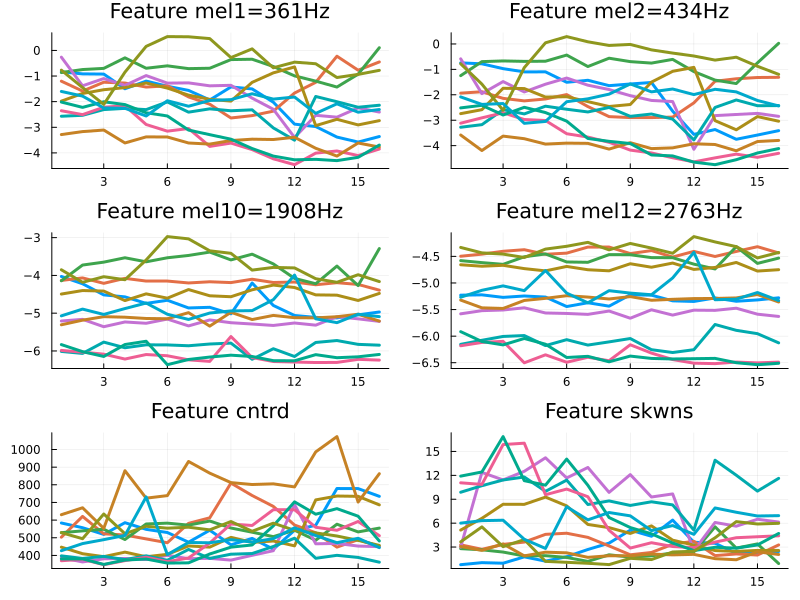

In [21]:
plots = []
for j in interesting_variables
    name = match(r_select, variable_names[j])[1]
    p = plot(X_test[pneumonia_indxs, j],
        linewidth=3,
        title="Feature $name",
        # xlabel="Samples",
        legend=false,
    )
    push!(plots, p)
end

n = length(interesting_variables)
nrows = Int(ceil(sqrt(n)))
ncols = Int(ceil(n / nrows))

final_plot = plot(plots..., layout=(nrows, ncols), size=(800, 600))
display(final_plot)

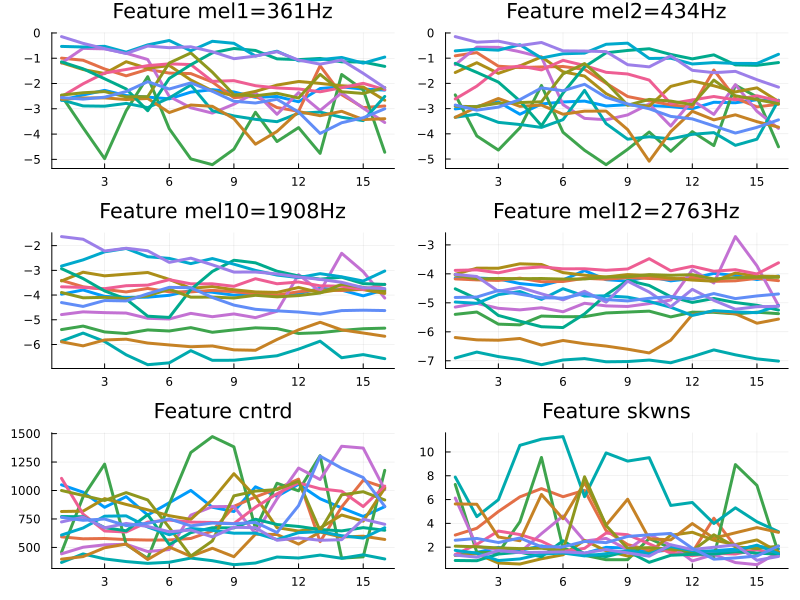

In [22]:
plots = []
for j in interesting_variables
    name = match(r_select, variable_names[j])[1]
    p = plot(X_test[healthy_indxs, j],
        linewidth=3,
        title="Feature $name",
        # xlabel="Samples",
        legend=false,
    )
    push!(plots, p)
end

n = length(interesting_variables)
nrows = Int(ceil(sqrt(n)))
ncols = Int(ceil(n / nrows))

final_plot = plot(plots..., layout=(nrows, ncols), size=(800, 600))
display(final_plot)